In [7]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn import metrics
import ast
from matplotlib import colors
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from collections import Counter, defaultdict
import numpy as np
from functools import reduce
from pathlib import Path
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
import time
import multiprocessing
from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [3]:
import json
import numpy as np
import sys
import pickle
import random

import keras

from keras.models import Model
from keras.layers import Bidirectional
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

np.set_printoptions(precision=2)

## 1. Research Question

For this project we are using two different datasets.
1. Amazon product review -> Classification
Each product is classified hierarchically into 3 levels of product category (Cat1, Cat2, Cat3).
The aim is to use various classification models in order to classify each review up to second level (Cat2).

2. A Tale of Two Cities book text -> Structured Perceptron
We used raw text of the book in order to predict Part of Speach for each word.
First we used Spacy.Pos to have a pre-annotation for each word and then we went throught the 2000 labels **manually** and correct/changed the annotations.
Both the Spacy annotaions and our annotations are included inthe data for a better comparision


## 2.1 Preprocessing

###  Classification Dataset (Amazon Review)

**NOTE**: Preprocessing steps take a very long time to run so you can just skip them and use the cleaned data
    that is provided in the upcoming parts

Each product is classified hierarchically into 3 levels of product category (`Cat1`, `Cat2`, `Cat3`).

Other fields of the dataset:
- `productId`: the review is given about this product
- `Title`: title of a review as given by the author
- `userId`: user ID of the author of the review
- `Helpfulness`: - whether the review is found helpful by other users
- `Score`: score of a review as rated by other users
- `Time`: timestamp of the review
- `Text`: text of a review

Level 1 categories are: health personal care, toys games, beauty, pet supplies, baby products, and grocery gourmet food.

Level 2 has 64 categories and level 3 has 510 categories.

As we don't care about the sentiment of the reviews here, we used the following steps for preprocessing:
1. Removing numbers, punctuations, non proper words
2. reducing the repetition of characters : Yesssss -> Yes
3. Removing Stop-words
4. lowering all the tokens
5. Lemmatization

In [4]:
train = pd.read_csv('data/train_40k.csv')

In [ ]:
# Correcting the repition of charecters like in : Yeeeeees -> Yes
from autocorrect import Speller
spell = Speller(lang='en')
original_text=train['Text']
for i in range(len(original_text)):
    original_text[i]=spell(original_text[i])
    

In [ ]:
# Cleening numbers, punctuations, and not proper words
import regex
import ast
import spacy
for i in range(len(original_text)):
    original_text[i] = regex.sub(r'\p{P}','', original_text[i])

pattern = r'[0-9]'
for i in range(len(original_text)):
    original_text[i] = re.sub(pattern, '',original_text[i] )
for i in range(len(original_text)):
    original_text[i] = re.sub(r'[^\w\s]','',original_text[i]).lower()

In [ ]:
original_text_df=pd.DataFrame(original_text)
original_text_df=original_text_df.rename(columns={'Text':'Original Text'})
original_text_df=pd.concat([train,original_text_df],axis=1)
text_to_lemmatize=original_text_df['Original Text']

In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english')) 
no_stop_text=[]
for i in range(len(text_to_lemmatize)):

    word_tokens = word_tokenize(text_to_lemmatize[i]) 

    filtered_sentence = [w for w in word_tokens if len(w)>1 if not w in stop_words] 
    no_stop_text.append(filtered_sentence)



In [ ]:
list_of_text=[]
for i in range(len(no_stop_text)):
    sentence = " ".join(no_stop_text[i])
    list_of_text.append(sentence)
    

In [ ]:
lemmas=[]
for i in range(len(list_of_text)):
    lemmas_per_review=[token.lemma_ for token in nlp(list_of_text[i]) if token.pos_ is not {'PROPN'}
        and not token.is_stop]
    lemmas.append(lemmas_per_review)
lemmas_series = pd.Series(lemmas) 
df_lemmas=pd.concat([original_text_df,lemmas_series], axis=1)
df_lemmas=df_lemmas.rename(columns={0:'lemmas'})

In [ ]:
df_lemmas.to_csv('df_lemmas.csv', index = False) # the cleaned dataset

In [10]:
import spacy
data1 = pd.read_csv('data/NLP_texts_df_lemmas.csv')
def joiner(s):
    return ' '.join(ast.literal_eval(s))
data1['lemmas_joined'] =  data1['lemmas'].apply(joiner)

train = pd.read_csv('data/train_40k.csv')
data1 = data1.dropna()
nlp = spacy.load('en_core_web_sm', disable=['tokenizer',  'parser', 'ner'])
tokens_old1 =[token.text for sentence in data1.Text for token in nlp(sentence) ]
tokens_new1 =[token.text for sentence in data1.lemmas_joined for token in nlp(sentence) ]

num_words_old1 = len(tokens_old1)
num_words_new1 = len(tokens_new1)

num_doc_old1 = len(train)
num_doc_new1 = len(data1)

num_types_old1 = len(Counter(tokens_old1))
num_types_new1 = len(Counter(tokens_new1))

 #### Statistics

In [11]:
pd.DataFrame([[num_words_old1,num_words_new1,num_types_old1,num_types_new1,num_doc_old1,num_doc_new1,np.array(num_words_new1)/np.array(num_doc_new1)]],
             columns=['Num Tokens old','Num Tokens new','Num types old','Num types new','Num docs old','Num docs new','Average doc lenght'],
             index=['Numbers'])

,Num Tokens old,Num Tokens new,Num types old,Num types new,Num docs old,Num docs new,Average doc lenght
Numbers,3332093,1370136,58308,52419,40000,39983,34.267964


### Structured Perceptron Dataset (the book)

Since we want to predict the part of speaches, we only cleaned the data out of punctuations, numbers, and signs.
Each document is one sentence out of a 2000 random sample of the whole book.
Also to make the process of annotaions faster and more robust we only considered sentences with lenght between 3 to 20 words

In [12]:
import re
import string
from random import sample
import spacy
import pandas as pd
import numpy as np

In [14]:
# documents=[line for line in open('AliceInWonderland.txt',encoding='utf8').readlines()]
with open('data/TaleOfTwoCities.txt',encoding='utf8') as f:
    text = f.read()
    text = re.sub(r'(M\w{1,2})\.', r'\1', text)
    text = re.sub('\n',' ',text)
sentences = re.split(r' *[\.\?!:][\'"\)\]]* *', text)
sentences_old = sentences.copy()

In [15]:
# Deleting information pages
del sentences[:13]
del sentences[-228:-1]

In [16]:
def remove_punctuation(s):
    s = re.sub('[“”]','',s)
    return s.translate(str.maketrans('', '', string.punctuation))

def space_eliminator(s):
    return re.sub('(\ ){2,}','',s)

sentences = list(map(remove_punctuation,sentences))
sentences = list(map(space_eliminator,sentences))

In [17]:
from collections import Counter

nlp = spacy.load('en_core_web_sm', disable=['tokenizer',  'parser', 'ner'])
tokens_old =[token.text for sentence in sentences_old for token in nlp(sentence) ]
tokens_new =[token.text for sentence in sentences for token in nlp(sentence) ]

num_words_old = len(tokens_old)
num_words_new = len(tokens_new)

num_doc_old = len(sentences_old)
num_doc_new = len(sentences)

num_types_old = len(Counter(tokens_old))
num_types_new = len(Counter(tokens_new))

#### Statistics

In [18]:
pd.DataFrame([[num_words_old,num_words_new,num_types_old,num_types_new,num_doc_old,num_doc_new,np.array(num_words_new)/np.array(num_doc_new)]],
             columns=['Num Tokens old','Num Tokens new','Num types old','Num types new','Num docs old','Num docs new','Average doc lenght'],
             index=['Numbers'])

,Num Tokens old,Num Tokens new,Num types old,Num types new,Num docs old,Num docs new,Average doc lenght
Numbers,166036,137178,11159,11544,8313,8073,16.992196


In [ ]:
# choosing sentences with lenght between 3 to 20 words to ease the labelling process
def len_chooser(s):
    if (len(s.split())<20 and len(s.split())>=3):
        return s

sentences_medium = list(map(len_chooser,sentences))
sentences_medium = list(filter(None, sentences_medium))
sentences_medium = list(map(space_eliminator,sentences_medium))


In [ ]:
# Choosing only 2000 documents to be labelled 
SP_samples = sample(sentences_medium,2000)

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
pos = [
    [token.pos_ for token in nlp(sentence)] 
    for sentence in SP_samples
]
tokens = [
    [token.text for token in nlp(sentence)] 
    for sentence in SP_samples
]

In [ ]:
SP_samples_df = pd.DataFrame(data=SP_samples,columns=['sentence'])
SP_samples_df['id']=SP_samples_df.index
SP_samples_df['pos']=pos
SP_samples_df['tokens']= tokens
SP_samples_df = SP_samples_df.apply(lambda x: x.explode() if x.name in ['pos','tokens'] else x)
SP_samples_df.to_excel('data/SP_samples_labeld.xlsx')

In [ ]:
SP_samples_df = pd.read_excel('data/SP_samples_annotated.xlsx') # Manually annotated data
SP_samples_df = SP_samples_df[SP_samples_df['pos']!='SPACE']
SP_samples_df['tokens'] = SP_samples_df['tokens'].str.lower()

In [ ]:
# Train-dev-test split for structured perceptrons
SP_samples_train_df=SP_samples_df[SP_samples_df['id']<= 2000*.5]
SP_samples_dev_df = SP_samples_df[(SP_samples_df['id']> 2000*.5) & (SP_samples_df['id']<= 2000*.75)]
SP_samples_test_df = SP_samples_df[SP_samples_df['id']> 2000*.75]

In [ ]:
# Creating the conll files
SP_samples_train_df['join'] = SP_samples_train_df['tokens'] + '\t' + SP_samples_train_df['pos']
for i, g in SP_samples_train_df.groupby('id')['join']:
    out = g.append(pd.Series({'new':' '}))
    out.to_csv('data/SP_samples_train_conll.data', index=False, header=None, mode='a')
    
SP_samples_dev_df['join'] = SP_samples_dev_df['tokens'] + '\t' + SP_samples_dev_df['pos']
for i, g in SP_samples_dev_df.groupby('id')['join']:
    out = g.append(pd.Series({'new':' '}))
    out.to_csv('data/SP_samples_dev_conll.data', index=False, header=None, mode='a')
    
SP_samples_test_df['join'] = SP_samples_test_df['tokens'] + '\t' + SP_samples_test_df['pos']
for i, g in SP_samples_test_df.groupby('id')['join']:
    out = g.append(pd.Series({'new':' '}))
    out.to_csv('data/SP_samples_test_conll.data', index=False, header=None, mode='a')

## Classification Data (Amazon Review)

## LDA and Topic Modeling

Since the aim is the category detection, we used topic models and LDA in order to better understand the data and how it is distributed

In [20]:
# read in instances and create Dictionary object w information about frequencies etc. 
data1 = pd.read_csv('data/NLP_texts_df_lemmas.csv')
def joiner(s):
    return ' '.join(ast.literal_eval(s))
data1['lemmas_joined'] =  data1['lemmas'].apply(joiner)

data1['lemmas_joined'] = data1['lemmas_joined'].apply(lambda x: x.replace('nt',''))
instances = list(data1.lemmas_joined.str.split())
phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=50, no_above=0.3)
print(dictionary, flush=True)

Dictionary(3041 unique tokens: ['description', 'indicate', 'photo', 'product', 'version']...)


In [21]:
#replace words by their numerical IDs and *their* frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [22]:
author2doc = defaultdict(list)
target_category = 'Cat1'
for i, category in enumerate(data1[target_category]):
    author2doc[category].append(i)
    
len(author2doc)

6

In [23]:
# Choosing the best number of topics using CV and UMass
coherence_values = []
author_model_list = []

dev_size = 15000

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(1, 10):
    author_model = AuthorTopicModel(corpus=list(ldacorpus[:dev_size]), 
                                    author2doc=dev_author2doc, # the only difference to LDA 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=0.5,
                                    random_state=42
                                   )
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))
print("Done!")

1 -1.6901176122630734 0.3433626319827219
2 -1.8081501483556295 0.3902366636604929
3 -1.8848598653059945 0.38294768785584027
4 -2.06618158919593 0.3935492355649129
5 -2.1168563893031025 0.3810054793465631
6 -1.9657010522959777 0.3878502778624337
7 -2.1954302560732555 0.39269036233524035
8 -2.475655653483071 0.37998415408716474
9 -2.3870685365626656 0.3987455578547061
Done!


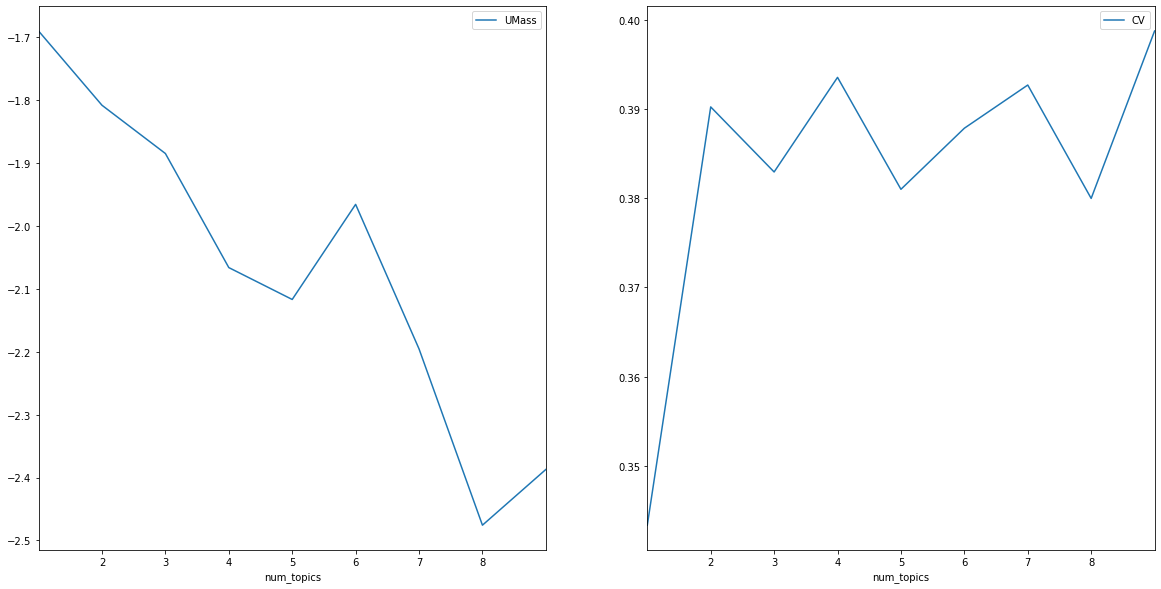

In [24]:
#Plotting the outcomes
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(2,9));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(2,9));

In [30]:
# train model with best number of topics
n_topics_author = 6 # based on the trade-oof between two charts
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)
author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.5,
                                random_state=42
)

2000.0


In [31]:
# get the topic descriptions
topic_sep = re.compile("0\.[0-9]{3}\*") # getting rid of useless formatting


# extract a list of tuples with topic number and descriptors from the model
author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]



In [32]:
author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "good", "taste", "like", "product", "try"
2 "product", "hair", "use", "skin", "smell"
3 "dog", "cat", "product", "work", "buy"
4 "toy", "play", "love", "old", "game"
5 "like", "work", "get", "look", "year"
6 "baby", "paper", "use", "great", "seat"


In [33]:
# initialize mapping from covariate(=author/category) to topic distro, set all to 0.0
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }
# update mappings from model
for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

        
target_categories = ['grocery gourmet food', 'toys games', 'beauty',
       'health personal care', 'baby products', 'pet supplies']
for category in target_categories:
    print(category, author_vecs[category])   

grocery gourmet food {'good, taste': 0.5873190308342009, 'product, hair': 0.08889865445437985, 'dog, cat': 0.06265278751631916, 'toy, play': 0.07181395787129582, 'like, work': 0.18424592830182523, 'baby, paper': 0.0}
toys games {'good, taste': 0.018575161103881035, 'product, hair': 0.02458469577549106, 'dog, cat': 0.061754731303440204, 'toy, play': 0.5643183764186089, 'like, work': 0.24898243744623738, 'baby, paper': 0.08178459795234146}
beauty {'good, taste': 0.1392181077881302, 'product, hair': 0.4753435102788758, 'dog, cat': 0.02286143251130295, 'toy, play': 0.0, 'like, work': 0.3312960992004219, 'baby, paper': 0.0239852800256367}
health personal care {'good, taste': 0.322970762106346, 'product, hair': 0.12370734431065826, 'dog, cat': 0.11711240161924799, 'toy, play': 0.0, 'like, work': 0.30911388473071083, 'baby, paper': 0.11835614026152771}
baby products {'good, taste': 0.01279490430583639, 'product, hair': 0.06101491434265903, 'dog, cat': 0.038791626591605774, 'toy, play': 0.0614

1 "good", "taste", "like", "product", "try"
2 "product", "hair", "use", "skin", "smell"
3 "dog", "cat", "product", "work", "buy"
4 "toy", "play", "love", "old", "game"
5 "like", "work", "get", "look", "year"
6 "baby", "paper", "use", "great", "seat"


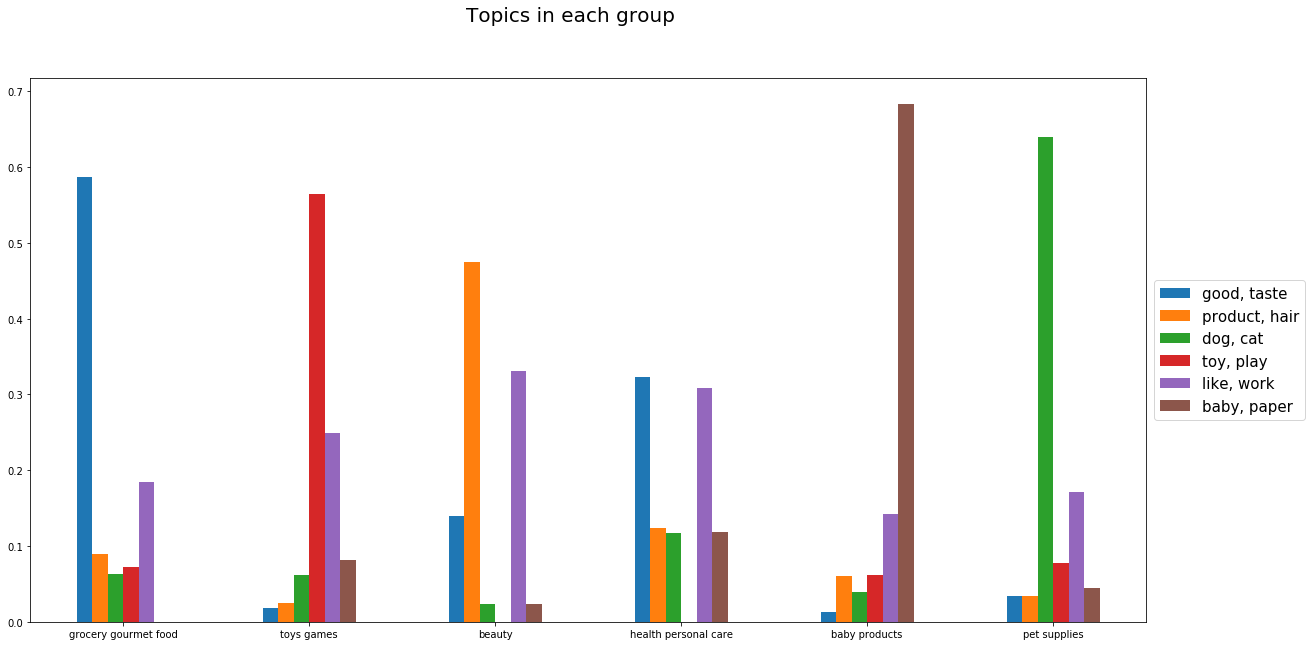

In [34]:
# Topic models in each group
author_df = pd.DataFrame.from_dict(author_vecs)
author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))
# plot it
fig, ax = plt.subplots(figsize=(20,10))
fig.suptitle('Topics in each group',fontsize=20)
author_df[target_categories].T.plot.bar(ax=ax,fontsize=10)
ax.tick_params(labelrotation='auto')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=15);

As expected each category is well differentiated from each other, as the most relevant topics for each of them is quite distinguished with respect to others. The only two categories that have two topics both relevant are “beauty” and “health personal care”. The former has “product, hair” and “life, work”, while the latter is characterised by topics such as “like, work” and “good, taste”; in this last case, most probably, it does not consider the eating aspect of it, but someone with good aesthete 

In [35]:
documents=data1['lemmas'].apply(str).tolist()

In [36]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(40000, 4339)


In [37]:
from sklearn.decomposition import TruncatedSVD # this also works with sparse matrices

# set number of latent components
k = 20

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

Wall time: 914 ms


In [38]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

Wall time: 16.8 s


In [39]:
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a matrix
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

In [40]:
terms = tfidf_vectorizer.get_feature_names()
show_topics(H, terms)

['easy, use, seat, car, easy use',
 'toy, play, son, month, month old',
 'taste, flavor, tea, bar, like',
 'product, great product, product work, skin, use',
 'game, play, fun, card, kid',
 'hair, dry, brush, dryer, shampoo',
 'year, old, year old, old son, old daughter',
 'dog, collar, treat, dog love, small',
 'price, amazon, store, good price, great price',
 'great, work, work great, great product, great price',
 'love, daughter, daughter love, doll, absolutely love',
 'good, quality, good product, good quality, good price',
 'nt, work, try, time, think',
 'recommend, highly, highly recommend, recommend product, definitely recommend',
 'smell, scent, like, skin, wear',
 'paper, baby, leak, bag, hughe',
 'order, item, receive, purchase, amazon',
 'cat, box, litter, litter box, clean',
 'buy, money, buy product, nt buy, cheap',
 'shave, razor, close, blade, electric']

In [41]:
sns.set_context('notebook')
def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('spring') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.legend()
    plt.show()

In [42]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

low_dim_svd = TruncatedSVD(n_components=3)
low_dim_nmf = NMF(n_components=3, init='nndsvd')

Z = X
categories = data1.Cat1

low_dim_U = low_dim_svd.fit_transform(Z)
low_dim_W = low_dim_nmf.fit_transform(Z)

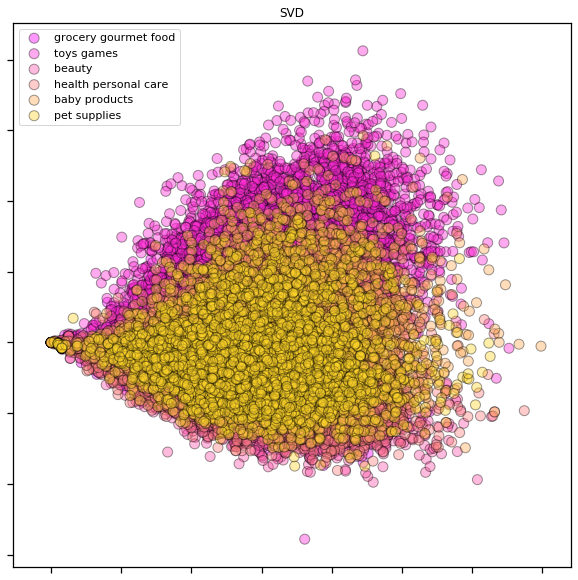

In [43]:
# LDA
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

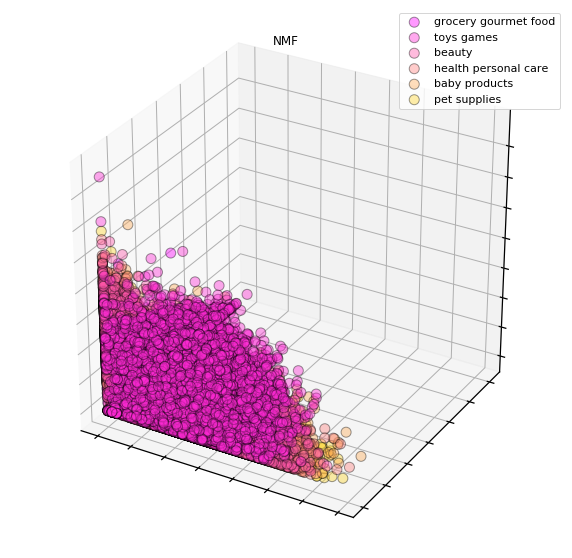

In [44]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=3)

In [86]:
## Structured Perceptron Dataset (the book)

# Word2Vec

In [ ]:
data2 =  pd.read_excel('data/SP_samples_annotated.xlsx')
data2 = data[[ 'sentence', 'tokens', 'pos']]
data2['tokens'] = data2['tokens'].str.lower()

In [10]:
def w2v_model(dataframe, min_count): # considering a minimum_count for different degrees of visualisation
                                     
    corpus = []
    for i in dataframe:
        corpus.append(i)
    
    corpus = [[el] for el in corpus]
    
    w2v_model = Word2Vec(size=100, # vector size
                     window=15, # window for sampling
                     sample=0.0001, # subsampling rate
                     iter=200, # iterations
                     negative=5, # negative samples
                     min_count= min_count, 
                     workers=-1, # parallelize to all cores
                     hs=0, # no hierarchical softmax
                     seed = 1) 
    
    w2v_model.build_vocab(corpus) #building vocabulary
    
    w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs) #training the model
    
    model = w2v_model.wv
    return model

In [11]:
# Creates a TSNE model and plots it
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word]) #creating token list
        labels.append(word) #creating the list of labels for each token
    
    # I am keeping two dimensions for visualisation purposes (since the dimensionality is quite high)
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23) 
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


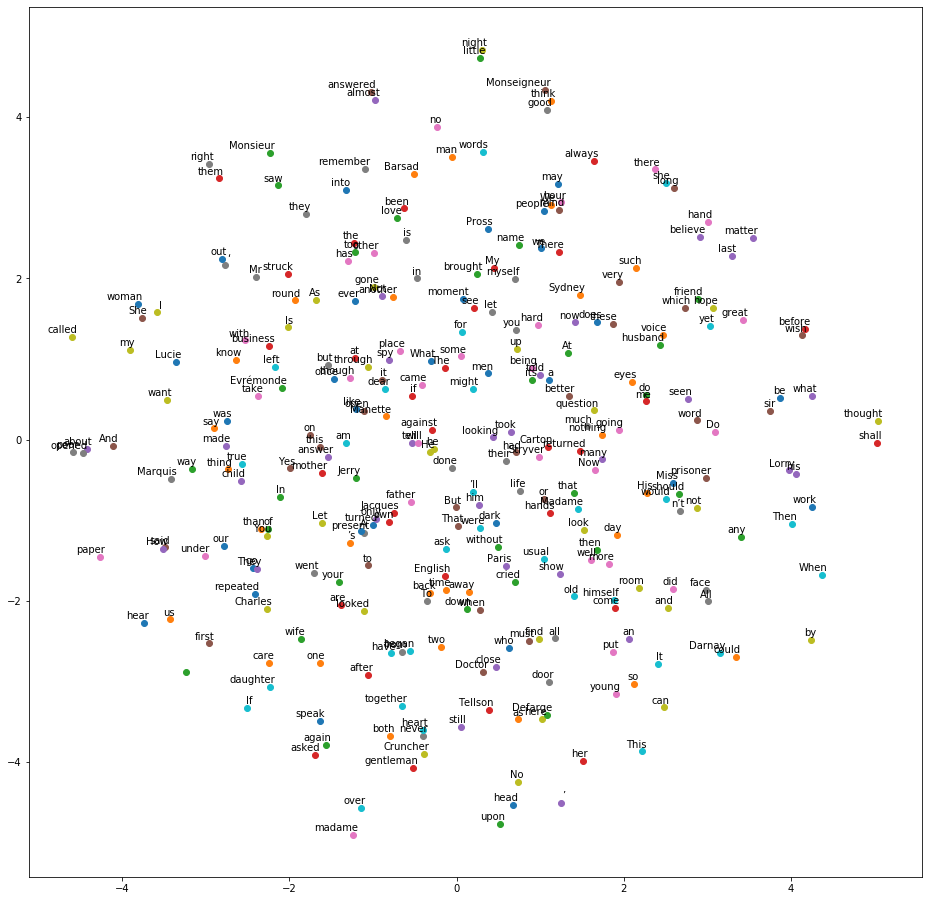

In [12]:
tokens = w2v_model(data2['tokens'], 10) 

tsne_plot(tokens)


After performing a word embedding on the 2000 random sentences with a word2vec, in order to visualise each of their distribution relative to the entire corpus, we applied a t-SNE dimensionality reduction. In particular, in this graph it can be observed how each word is localised in relation to others, by showing the most similar ones in close neighbourhoods. Moreover, this is not the entire corpus we had, but only those with a minimum count of 10 such that the graph is not too dense for visualisation purposes.

# 4. Prediction

## Classification

## Importing Clean dataset

In [5]:
import numpy as np
import pandas as pd
import time
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 8, 'font.style': 'normal', 'font.family':'serif'})

In [4]:
# Importing data to train and calibrate the model
data = pd.read_csv('data/NLP_texts_df_lemmas.csv')
data['Cat1_Cat2'] = data['Cat1'] + '/' + data['Cat2']


In [9]:
## Creating the final table to compare models
columns_names = ['F1_Micro']
Table_Predictions = pd.DataFrame(columns=columns_names)

## 4. Model

Given our dataset, although the optimal method would be to implement a hierarchical model predicting the subsequent category based on the previous one (so a conditional modeling), we opted for a **flat classification**. The reason behind this choice is because in this way we are able to explore in depth all the sub-categories, so all the available options. On the other hand, a conditional model, that does not backpropagate the errors, would interpolate the noises by carrying the errors, if any, of the previous level and limiting the category alternatives. This would be too biased and blind to all the options, given its strong dependance on the prediction previously computed.  

In our model, we considered as target label the **concatenation of level 1 and level 2 categories**. We excluded the third-level categories because otherwise the number of classes would be too large.

As for the performance, we chose `f1_score_micro` as evaluation metrics, because it doesn't favour any particular class and we don't want to penalize or favour one over the others.

------------------------------------------------------------------------------------

Before diving into the model, we did some exploratory data analysis. 

Text(0.5, 0, 'count')

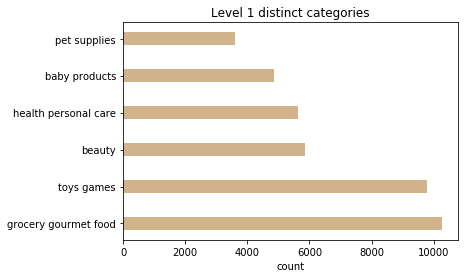

In [5]:
## Plotting the review counts for each distinct category in the first category level. They are 6

fig, ax = plt.subplots()

cat1 = data.Cat1.unique() #list of unique categories for Category 1

ax.barh(cat1, data.Cat1.value_counts(),color='tan',height=0.35)
ax.set_title('Level 1 distinct categories')
ax.set_xlabel('count')

Plotting per each distict level1 category the count of its corresponding level2 category

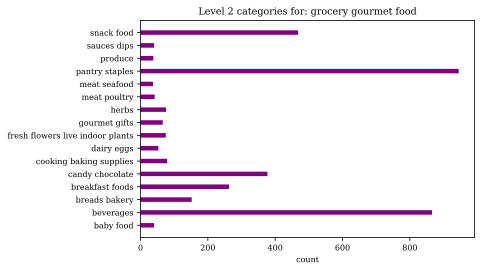

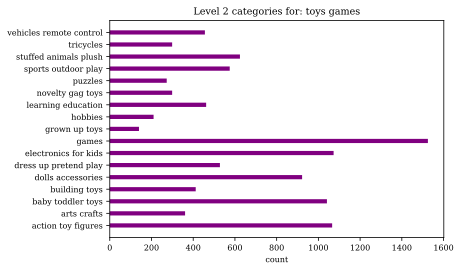

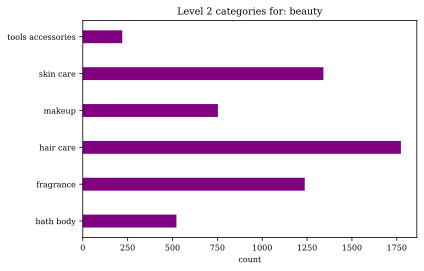

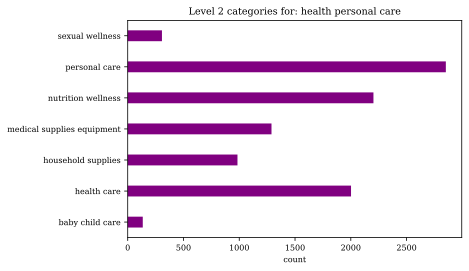

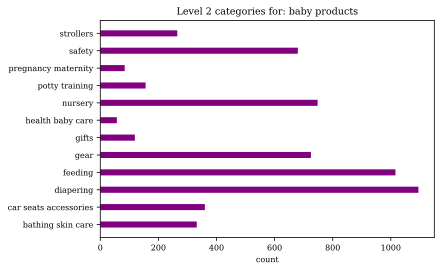

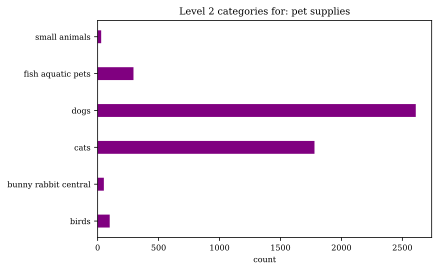

In [11]:
# df containing only distinct Cat1 and Cat2 with their correspective reviews count
df_cat1cat2 = data.groupby(['Cat1','Cat2']).count()[['productId']].reset_index()

for i in cat1: #cat1 is a list of th
    fig, ax = plt.subplots()
    category = df_cat1cat2[ df_cat1cat2.Cat1==i ]['Cat2'].unique()
    count = df_cat1cat2[ df_cat1cat2.Cat1==i ].productId
    ax.barh(category, count,color='purple',height=0.35)
    ax.set_title('Level 2 categories for: {}'.format(i))
    ax.set_xlabel('count')


--------------------------------------------------------

In [12]:
# randomly split the data into training, development and test sets
train = data.sample(frac=0.5)
dev = data.sample(frac=0.25)
test = data.sample(frac=0.25)
print('Lenght for train, dev and test: ',len(train), len(dev), len(test))

# label that want to predict
target = 'Cat1_Cat2' 

# Train, development and test inputs for our model
y_train = train[target]
y_dev = dev[target]
y_test = test[target]

print('Number different labels: ', len(y_train.unique()))

X_train = train['lemmas']
X_dev = dev['lemmas']
X_test = test['lemmas']

Lenght for train, dev and test:  20000 10000 10000
Number different labels:  64


In [13]:
# Transforming text to matrix with tfidf vectorizer to create our models
vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.7,
                             analyzer='word',
                             sublinear_tf=True,
                            stop_words = 'english')

X_train = vectorizer.fit_transform(X_train)
X_dev = vectorizer.transform(X_dev)
X_test = vectorizer.transform(X_test)
print('X length after TFDIF for train, dev and test: ',X_train.shape, X_dev.shape, X_test.shape)

X length after TFDIF for train, dev and test:  (20000, 4441) (10000, 4441) (10000, 4441)


## Baselines
## 4.1 Dummy classifier

In [14]:
import numpy as np
import pandas as pd
import time
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
#import xgboost as xgb

from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 8, 'font.style': 'normal', 'font.family':'serif'})

In [15]:
# finding the most frequent class in the training data
most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)

# Dummy Baseline
# getting the performance on the development set
dummy_pred = most_frequent.predict(X_test)
f1_score_dummy = f1_score(y_dev, dummy_pred, average='micro')
print(f1_score_dummy)

0.0702


In [16]:
# Updating our final table
model_name_1 = 'Most-Frequent-Label Baseline'
Table_Predictions.loc[model_name_1,columns_names[0]] = f1_score_dummy
Table_Predictions

,F1_Micro
Most-Frequent-Label Baseline,0.0702


## 4.2 Logistic Baseline

In [17]:
# Defining the baseline logistic classifier
classifier = LogisticRegression(n_jobs=-1) # Simple logistic Regression
classifier.fit(X_train, y_train)

# getting the performance on the development set
log_base_pred = classifier.predict(X_test)
f1_score_log_base = f1_score(y_test, log_base_pred, average='micro')
print(f1_score_log_base)

0.6711


In [18]:
# Updating our final table
model_name_2 = 'Logistic Baseline'
Table_Predictions.loc[model_name_2,columns_names[0]] = f1_score_log_base
Table_Predictions

,F1_Micro
Most-Frequent-Label Baseline,0.0702
Logistic Baseline,0.6711


## 4.3 Predictive Models
## 4.3.1 Logistic Weighted and Regularized

In [19]:
## Selecting the best C and class_weight. Check on the development dataset for the Logistic Regression

# Parameters to test
best_c = None
best_class = None
best_performance = 0.0

# Time check
time_start = time.time()

# Loop to test the data
for c in [50, 20, 10, 5, 2, 0.5, 0.1, 0.05, 0.01]:
    for classe in ['balanced',None]:
        base_clf = LogisticRegression(n_jobs=-1, 
                                          multi_class='auto', 
                                          solver='lbfgs',
                                          class_weight=classe, # temporary class weight
                                          C=c #temporary C
                                         )

        base_clf.fit(X_train, y_train)
        predictions_clf = base_clf.predict(X_dev)
        score = f1_score(y_dev, predictions_clf, average='micro')
        if score > best_performance:
            best_performance = score
            best_c = c
            best_class = classe
            print("New best performance: {}".format(score))
            
# End time
time_end = time.time()

# Some outputs
print(best_c)
print(best_class)
print('Computation time (minutes): ',(int((time_end-time_start)/60)))

New best performance: 0.792
New best performance: 0.7965
50
None
Computation time (minutes):  4


In [20]:
# Selecting the best model 
clf_best = LogisticRegression(n_jobs=-1, 
                                          multi_class='auto', 
                                          solver='lbfgs',
                                          class_weight=best_class,
                                          C=best_c
                                         )
# fitting this classifier on the entire training data
clf_best.fit(X_train, y_train)

# getting the performance on the test set
log_best_pred = clf_best.predict(X_test)
print(f1_score(y_test, log_best_pred, average='micro'))

0.7965


In [21]:
# Updating our final table
model_name_3 = 'Logistic Weighted and Regularized'
f1_score_log2 = f1_score(y_test, log_best_pred, average='micro')

Table_Predictions.loc[model_name_3,columns_names[0]] = f1_score_log2
Table_Predictions

,F1_Micro
Most-Frequent-Label Baseline,0.0702
Logistic Baseline,0.6711
Logistic Weighted and Regularized,0.7965


## 4.3.2 Random Forest

In [22]:
## Selecting the best number of estimator. Check on the development dataset for the Random Forest Classifier

# Parameters to test
best_n_estimators = None
best_performance = 0.0

# Time check
time_start = time.time()

# Loop to test the data
for n_estimators in np.arange(start=200, stop=700, step=100, dtype=np.int32):
    print('Testing n_estimators = ',n_estimators)
    base_clf = RandomForestClassifier(n_estimators=n_estimators,
                                      random_state=0, 
                                      n_jobs=-1,
                                     class_weight= 'balanced')

    base_clf.fit(X_train, y_train)
    predictions_clf = base_clf.predict(X_dev)
    score = f1_score(y_dev, predictions_clf, average='micro')
    if score > best_performance:
        best_performance = score
        best_n_estimators = n_estimators
            
# End time
time_end = time.time()

# Some outputs
print('Best n_estimator: ',best_n_estimators)
print('Best score: ',best_performance)
print('Computation time (minutes): ',(int((time_end-time_start)/60)))

Testing n_estimators =  200
Testing n_estimators =  300
Testing n_estimators =  400
Testing n_estimators =  500
Testing n_estimators =  600
Best n_estimator:  500
Best score:  0.7681
Computation time (minutes):  5


In [23]:
# Selecting the best model 
clf_best = RandomForestClassifier(n_estimators=500,
                                      random_state=0, 
                                      n_jobs=-1,
                                     class_weight= 'balanced')
                                         
# fitting this classifier on the entire training data
clf_best.fit(X_train, y_train)

# getting the performance on the test set
randomforest_pred = clf_best.predict(X_test)
print(f1_score(y_test, randomforest_pred, average='micro'))

0.7696


In [24]:
# Updating our final table
model_name_4 = 'Random Forest'
f1_score_rf = f1_score(y_test, randomforest_pred, average='micro')

Table_Predictions.loc[model_name_4,columns_names[0]] = f1_score_rf
Table_Predictions

,F1_Micro
Most-Frequent-Label Baseline,0.0702
Logistic Baseline,0.6711
Logistic Weighted and Regularized,0.7965
Random Forest,0.7696


## 4.3.3 Support vector classifier

In [40]:
## Selecting the best C. Check on the development dataset for the Support Vector Classifier

# Parameters to test
best_c = None
best_performance = 0.0

# Time check
time_start = time.time()

# Loop to test the data
for c in [100,10,1,0.1]:
    base_clf = SVC(kernel='rbf', 
                   class_weight='balanced',
                   C=c)

    base_clf.fit(X_train, y_train)
    predictions_clf = base_clf.predict(X_dev)
    score = f1_score(y_dev, predictions_clf, average='micro')
    if score > best_performance:
        best_performance = score
        best_c = c
            
# End time
time_end = time.time()

# Some outputs
print('Best C: ',best_c)
print('Best score: ',best_performance)
print('Computation time (minutes): ',(int((time_end-time_start)/60)))

Best C:  100
Best score:  0.8041000000000001
Computation time (minutes):  23


In [41]:
# Selecting the best model 
clf_best = SVC(kernel='rbf', 
                   class_weight='balanced',
                   C=10)
                                         
# fitting this classifier on the entire training data
clf_best.fit(X_train, y_train)

# getting the performance on the test set
svc_pred = clf_best.predict(X_test)
print(f1_score(y_test, svc_pred, average='micro'))

0.8067


In [42]:
# Updating our final table
model_name_5 = 'Support Vector Classifier'
f1_score_svc = f1_score(y_test, svc_pred, average='micro')

Table_Predictions.loc[model_name_5,columns_names[0]] = f1_score_svc
Table_Predictions

,F1_Micro
Most-Frequent-Label Baseline,0.0702
Logistic Baseline,0.6711
Logistic Weighted and Regularized,0.7965
Random Forest,0.7696
Support Vector Classifier,0.8067


## 4.3.4 Boosting

In [ ]:
## Selecting the best  number of estimator. Check on the development dataset for the famous XG boost
import xgboost as xgb
# Parameters to test
best_n_estimators = None
best_performance = 0.0

# Time check
time_start = time.time()

# Loop to get the best number of estimator
for n_estimators in np.arange(start=100, stop=500, step=100, dtype=np.int32):
    print('Testing n_estimators = ',n_estimators)
    base_clf = xgb.XGBClassifier(n_estimators=n_estimators,
                                      random_state=0, 
                                     objective = 'multi:softprob', #multiple classifications
                                      n_jobs=-1)

    base_clf.fit(X_train, y_train)
    predictions_clf = base_clf.predict(X_dev)
    score = f1_score(y_dev, predictions_clf, average='micro')
    if score > best_performance:
        best_performance = score
        best_n_estimators = n_estimators
            
# End time
time_end = time.time()

# Some outputs
print('Best n_estimator: ',best_n_estimators)
print('Best score: ',best_performance)
print('Computation time (minutes): ',(int((time_end-time_start)/60)))

In [48]:
# Selecting the best model 
clf_best = xgb.XGBClassifier(n_estimators=300,
                                      random_state=0, 
                                     objective = 'multi:softprob',
                                      n_jobs=-1)

                                         
# fitting this classifier on the entire training data
clf_best.fit(X_train, y_train)

# getting the performance on the test set
boosting_pred = clf_best.predict(X_test)
print(f1_score(y_test, boosting_pred, average='micro'))

[19:16:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7825


In [50]:
# Updating our final table
model_name_6 = 'Xgboost'
f1_score_boosting = f1_score(y_test, boosting_pred, average='micro')

Table_Predictions.loc[model_name_6,columns_names[0]] = f1_score_boosting
Table_Predictions.sort_values(by='F1_Micro',axis=0,ascending=False)

,F1_Micro
Support Vector Classifier,0.8067
Logistic Weighted and Regularized,0.7965
Xgboost,0.7825
Random Forest,0.7696
Logistic Baseline,0.6711
Most-Frequent-Label Baseline,0.0702


In [51]:
Table_Predictions.to_csv('Table_Predictions.csv')

## 4.4 Bootstrap Sampling significance tests

In [53]:
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure that the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on the entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to the subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on the subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [54]:
### Best model Support Vector Classifier ###

p_value, deltas = bootstrap_sample(svc_pred, dummy_pred, y_test)
print(p_value, p_value < 0.01)


p_value, deltas = bootstrap_sample(svc_pred, log_base_pred, y_test)
print(p_value, p_value < 0.01)

Base difference: 0.8067 vs. 0.0735
0.0 True
Base difference: 0.8067 vs. 0.6711
0.0 True


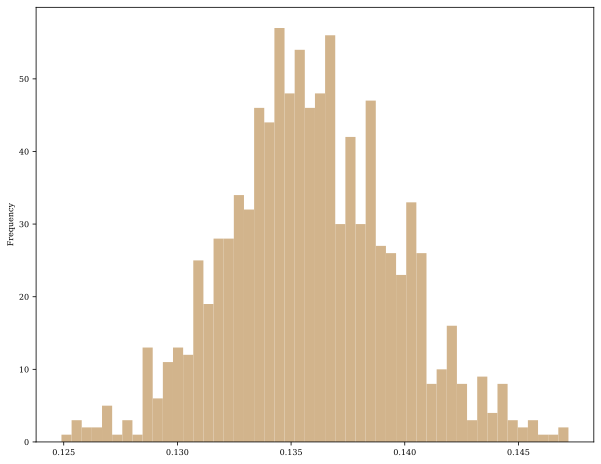

In [57]:
# The base difference is relevant compared to the two other baselines
figure = plt.figure(figsize=(10,8))
pd.Series(deltas).plot.hist(bins=50,color = "tan")
plt.show()

## 4.5 Visualization

#### Plotting the F1 scores for each predictive method used

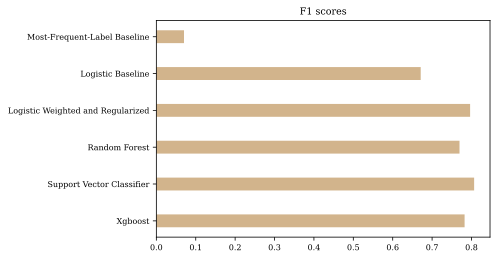

In [59]:
methods = Table_Predictions.index.tolist()
f1_scores = Table_Predictions.F1_Micro
fig, ax = plt.subplots()
ax.barh(methods,f1_scores,color='tan',height=0.35)
ax.set_title('F1 scores')
ax.invert_yaxis()

#### Confusion matrix to check the predictions

In [60]:
# defining function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.PuRd, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    """
    
    cm = confusion_matrix(y_true, y_pred).T
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

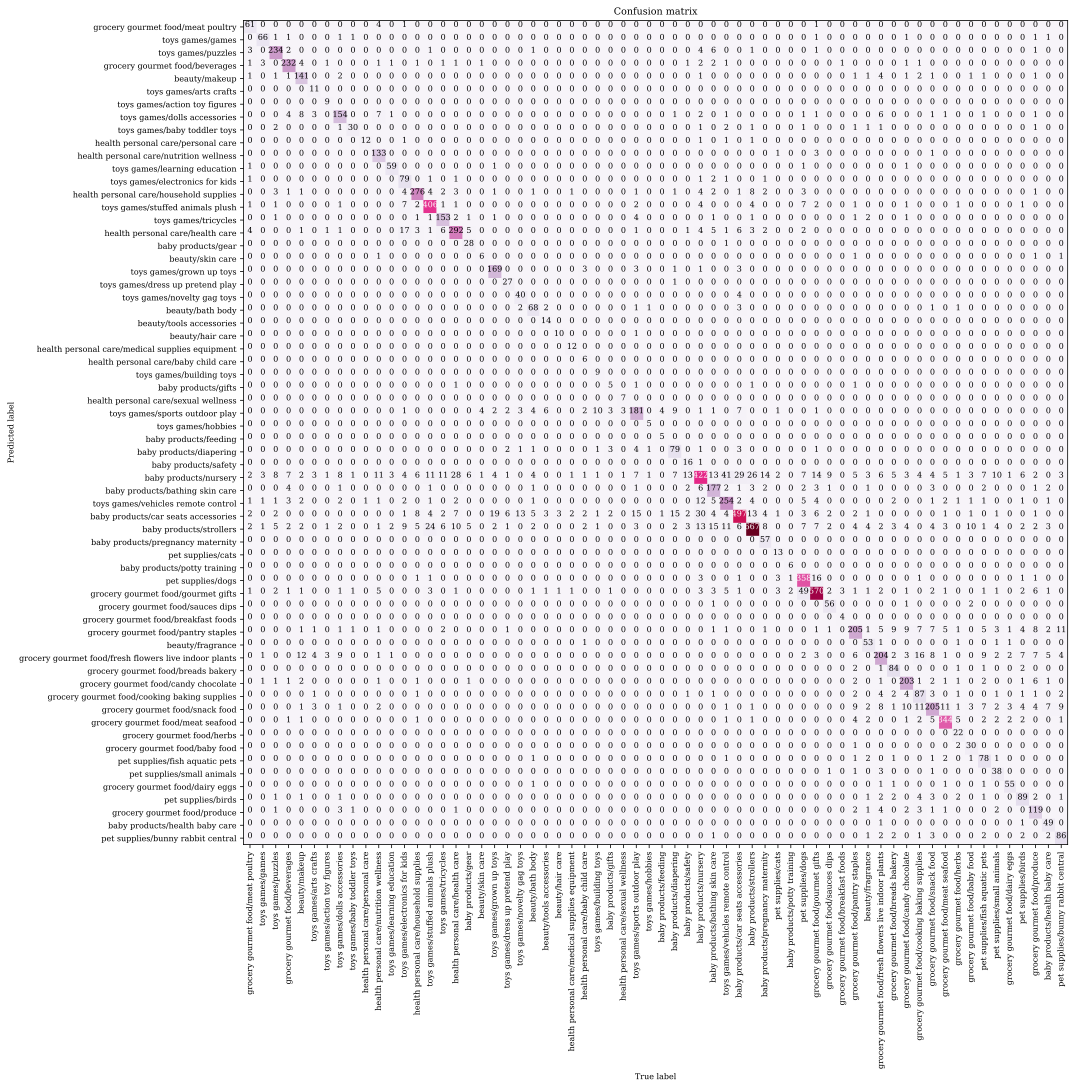

In [61]:
# Confusion Matrix for the support vector classifier against the true labels

plot_confusion_matrix( y_true=y_test, y_pred=svc_pred, 
    classes=data.Cat1_Cat2.unique().tolist(),
    figsize=(15,15))

# Structured Perceptron

In [45]:
np.set_printoptions(precision=2)

users = re.compile('@[^ ]+')
numbers = re.compile('[0-9]')
urls = re.compile("(https?:\/\/)?(?:www\.|(?!www))?[^\s\.]+\.[^\s]{2,}|(www)?\.[^\s]+\.[^\s]{2,}")

In [46]:
class StructuredPerceptron(object):
    """
    implements a structured perceptron as described in Collins 2002,
    with updates from https://explosion.ai/blog/part-of-speech-pos-tagger-in-python
    """

    def __init__(self):
        """
        initialize model parameters
        """
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        self.weight_totals = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        self.timestamps = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight

        self.tag_dict = defaultdict(set) #word -> {tags}

        self.START = "__START__"
        self.END = "__END__"
        
        
    def normalize(self, word):
        """
        lowercase word, and replace numbers, user names, and URLs
        """
        return re.sub(urls, 'URL', re.sub(users, '@USER', re.sub(numbers, '0', word.strip().lower())))

    
    def evaluate(self, data_instances, method='greedy'):
        correct = 0
        total = 0
        for (words, tags) in data_instances:
            preds = self.predict(words, method=method)
            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            correct += matches
            total += len(tags)
        return correct/total
        
    
    def fit(self, file_name, dev_file=None, iterations=10, learning_rate=0.25, inference='greedy', verbose=False):
        """
        read in a CoNLL-format file, extract features to train weight vector
        """        
        # initialize tag dictionary for each word and get tag set
        instances = [(words, tags) for (words, tags) in self.read_conll_file(file_name)]
        for (words, tags) in instances:
            self.tags.update(set(tags))

            for word, tag in zip(words, tags):
                self.tag_dict[self.normalize(word)].add(tag)
        
        if dev_file:
            dev_instances = [(words, tags) for (words, tags) in self.read_conll_file(dev_file)]
            
        # iterate over data
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration+1), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances)
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                # get prediction
                prediction = self.predict(words, method=inference)

                # derive global features
                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)
                                    
                # update weight vector:
                # 1. move closer to true tag
                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                # 2. move further from wrong tag
                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count
                        
                # compute training accuracy for this iteration
                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                # output examples
                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    print(list(zip(words, 
                                   [self.normalize(word) for word in words], 
                                   tags, 
                                   prediction)), file=sys.stderr, flush=True)
            
            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
            if dev_file:
                print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances, method=inference)), file=sys.stderr, flush=True)
         
        # average weights
        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged


    def get_features(self, word, previous_tag2, previous_tag, words, i):
        """
        get all features that can be derived from the word and previous tags
        """
        prefix = word[:3]
        suffix = word[-3:]

        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 # previous tag
                    'PREV_TAG2={}'.format(previous_tag2),                 # two-previous tag
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  # tag bigram
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            # word-tag combination
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),        # prefix and tag
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),        # suffix and tag
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
                    'BIAS'
            }
        return features
    
    
    def get_global_features(self, words, predicted_tags, true_tags):
        '''
        sum up local features
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START
        
        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):
            # get the predicted features. NB: use j+1, since context is longer than words
            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            # update feature correlation with true and predicted tag
            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features
            
    
    def get_scores(self, features):
        """
        predict scores for each tag given features
        """
        scores = defaultdict(float)
        
        # add up the scores for each tag
        for feature in features:
            if feature not in self.feature_weights:
                continue
            weights = self.feature_weights[feature]
            for tag, weight in weights.items():
                scores[tag] += weight

        # return tag scores
        if not scores:
            # if there are no scores (e.g., first iteration),
            # simply return the first tag with score 1
            scores[list(self.tags)[0]] = 1
        
        return scores


    def predict(self, words, method='greedy'):
        '''
        predict tags using one of two methods
        '''
        if method == 'greedy':
            return self.predict_greedy(words)
        elif method == 'viterbi':
            return self.predict_viterbi(words)


    def predict_viterbi(self, words):
        '''
        predict using Viterbi decoding
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        N = len(words)
        M = len(self.tags) #number of tags
        tags = sorted(self.tags)

        # create trellis of size M (number of tags) x N (sentence length)
        Q = np.ones((M, N)) * float('-Inf')
        backpointers = np.ones((M, N), dtype=np.int16) * -1 #backpointers

        # initialize probs for tags j at position 1 (first word)
        features = self.get_features(words[0], self.START, self.START, context, 1)
        scores = self.get_scores(features)
        allowed_initial_tags = self.tag_dict[context[1]]

        for j in range(M):
            if not allowed_initial_tags or tags[j] in allowed_initial_tags:
                Q[j,0] = scores[tags[j]]

        # filling the lattice, for every position and every tag find viterbi score Q
        for i in range(1, N):
            allowed_tags = self.tag_dict[context[i+1]]

            # for every previous tag
            for j in range(M):
                best_score = 0.0#float('-Inf')
                prev_tag = tags[j]

                # skip impossible tags
                allowed_previous_tags = self.tag_dict[context[i]]
                if allowed_previous_tags and prev_tag not in allowed_previous_tags:
                    continue

                best_before = Q[j,i-1] # score of previous tag

                # for every possible pre-previous tag
                for k in range(M):
                    if i == 1:
                        prev2_tag = self.START
                    else:
                        prev2_tag = tags[k]
                        # skip impossible tags
                        allowed_previous2_tags = self.tag_dict[context[i-1]]
                        if allowed_previous2_tags and prev2_tag not in allowed_previous2_tags:
                            continue

                    # get features of word i with the two previous tags
                    features = self.get_features(words[i], prev2_tag, prev_tag, context, i+1)
                    scores = self.get_scores(features)

                    # update best score
                    for t in range(M):
                        tag = tags[t]
                        # if word is unknown, use all tags, otherwise allowed ones
                        if not allowed_tags or tag in allowed_tags:
                            tag_score = best_before + scores[tag]

                            if tag_score > best_score:
                                Q[t,i] = tag_score
                                best_score = tag_score
                                backpointers[t,i] = j

        # final best
        best_id = Q[:,-1].argmax()

        # print best tags in reverse order
        predtags = [tags[best_id]]

        for i in range(N-1,0,-1):
            idx = backpointers[best_id, i]
            predtags.append(tags[idx])
            best_id = idx

        #return reversed predtags
        return predtags[::-1]         

    
    def predict_greedy(self, words):
        '''
        greedy prediction
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]
                
        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        out = []

        for j, word in enumerate(words):
            # for unambiguous words, just look up the tag
            predicted_tag = list(self.tag_dict[context[j+1]])[0] if len(self.tag_dict[context[j+1]]) == 1 else None

            if not predicted_tag:
                # get the predicted features. NB: use j+1, since context is longer than words
                prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)
                scores = self.get_scores(prediction_features)
                
                # predict the current tag
                predicted_tag = max(scores, key=scores.get)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

            out.append(predicted_tag)

        return out
    
        
    def read_conll_file(self, file_name):
        """
        read in a file with CoNLL format:
        word1    tag1
        word2    tag2
        ...      ...
        wordN    tagN

        Sentences MUST be separated by newlines!
        """
        current_words = []
        current_tags = []

        with open(file_name, encoding='utf-8') as conll:
            for line in conll:
                line = line.strip()

                if line:
                    word, tag = line.split('\t')
                    current_words.append(word)
                    current_tags.append(tag)

                else:
                    yield (current_words, current_tags)
                    current_words = []
                    current_tags = []

        # if file does not end in newline (it should...), check whether there is an instance in the buffer
        if current_tags != []:
            yield (current_words, current_tags)
        

    def save(self, file_name):
        """
        save model as pickle file
        """
        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
            # pickle cannot save default_dictionaries
            # => make copy and turn into regular dictionaries
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict, self.tags),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):
        """
        load model from pickle file
        """
        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags = parameters
            self.tags = tags

            # pickle cannot store defaultdicts, so we need a 2-step process
            # 1. initialize
            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)
            
            # 2. update
            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None

In [48]:
import random
sp = StructuredPerceptron()
inference_method = 'greedy'
%time sp.fit('data/SP_samples_train_conll.data', dev_file='data/SP_samples_dev_conll.data', iterations=10, inference=inference_method)
sp.save('model_greedy.pickle')

.................................................1000
	52417 features
	Training accuracy: 0.87

	Development accuracy: 0.81

.................................................1000
	56596 features
	Training accuracy: 0.93

	Development accuracy: 0.82

.................................................1000
	57892 features
	Training accuracy: 0.96

	Development accuracy: 0.84

.................................................1000
	58559 features
	Training accuracy: 0.97

	Development accuracy: 0.83

.................................................1000
	58917 features
	Training accuracy: 0.97

	Development accuracy: 0.83

.................................................1000
	59150 features
	Training accuracy: 0.98

	Development accuracy: 0.83

.................................................1000
	59293 features
	Training accuracy: 0.98

	Development accuracy: 0.83

.................................................1000
	59408 features
	Training accuracy: 0.98

	Development accuracy: 0.83



Wall time: 18.2 s


saving model... done


In [49]:
sp2 = StructuredPerceptron()
inference_method = 'viterbi'
%time sp2.fit('data/SP_samples_train_conll.data', dev_file='data/SP_samples_dev_conll.data', iterations=10, inference=inference_method)

sp2.save('model_viterbi.pickle')

.................................................1000
	52413 features
	Training accuracy: 0.88

	Development accuracy: 0.80

.................................................1000
	56359 features
	Training accuracy: 0.94

	Development accuracy: 0.81

.................................................1000
	57613 features
	Training accuracy: 0.95

	Development accuracy: 0.83

.................................................1000
	58096 features
	Training accuracy: 0.96

	Development accuracy: 0.82

.................................................1000
	58448 features
	Training accuracy: 0.97

	Development accuracy: 0.82

.................................................1000
	58677 features
	Training accuracy: 0.97

	Development accuracy: 0.83

.................................................1000
	58796 features
	Training accuracy: 0.98

	Development accuracy: 0.81

.................................................1000
	58923 features
	Training accuracy: 0.98

	Development accuracy: 0.82



Wall time: 1min 17s


saving model... done


In [55]:
# Now implementing the model on the test set
test_instances = [(words, tags) for (words, tags) in sp.read_conll_file('data/SP_samples_test_conll.data')]
Greedy_test_accuracy = sp.evaluate(test_instances,method='greedy')
print('The greedy test accuracye is:',Greedy_test_accuracy)
                                   
viterbi_test_accuracy = sp.evaluate(test_instances,method='viterbi')
print('The viterbi test accuracye is:',viterbi_test_accuracy)

The greedy test accuracye is: 0.842687074829932
The viterbi test accuracye is: 0.8048469387755102


In [56]:
# comparing the two models
print(sp.predict('We are realy enjoying NLP'.split(), method='greedy'))
print(sp2.predict('We are realy enjoying NLP'.split(), method='viterbi'))

['PRON', 'VERB', 'ADV', 'ADV', 'ADV']
['PRON', 'VERB', 'AUX', 'VERB', 'ADP']


# Neural Network Architecture

A **Recurrent Neural Networks (RNN)** is preferred here since the data at hand is not visual (which would prefer Convolutional Neural Networks) and because, since we have sentences from a book, the past plays an important role in determining the pos of the future words to be predicted. So, we want to predict the future data in a sequential manner as accurately as possible.

Moreover, in this notebook both the unidirectional Long-Short Term Memory (LSTM) and the Bi-directional LSTM will be analysed and compared 

In [57]:
data2 =  pd.read_excel('data/SP_samples_annotated.xlsx')
data2 = data[[ 'sentence', 'tokens', 'pos']]
data2['tokens'] = data2['tokens'].str.lower()

In [58]:
# Combines into a list each token and pos respectively and puts them into one list 
def get_list(check_column, df_column): #I have added a line in the excel file at data['sentence']
    ll = []
    inner = []
    for i in range(1,len(check_column)): #i is a number
        inner.append(df_column[i-1])
        if check_column.iloc[i] == check_column.iloc[i-1]:
            continue
        else:
            ll.append(inner)
            inner = []
    return ll

In [59]:
# Unique values of tokens and pos
wordset = set(data2['tokens'].dropna())
tagset = set(data2['pos'].dropna())

new_tokens = get_list(data2['sentence'], data2['tokens'])
new_pos = get_list(data2['sentence'], data2['pos'])

new = list(zip(new_tokens, new_pos)) #zip together the tokens and their respective pos in two consecutive lists

# Since we already chose a random sample of the data there is no need for shuffling in this step

# Divide in train, development, test datasets
train_tokens = new[:1000]
dev_tokens = new[1000:1500]
test_tokens = new[1500:]
train_pos = new[:1000]
dev_pos = new[1000:1500]
test_pos = new[1500:]

The padding below is not really needed for the Neural Network since _keras_ does it already, but it might be useful for the Structured perceptron (and it is useful to find MAX_LENGTH later) 

In [60]:
# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # token for padding
word2int[UNK] = 1  # token for unknown words
 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0 
int2tag = {i:tag for tag, i in tag2int.items()} # to translate it back


def convert2ints(instances):
    result = []
    for (words, tags) in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result        

In [61]:
# Converting from words to integers for train set
train_sentences_int = convert2ints(train_tokens)
train_tags_int = convert2ints(train_pos)

# Converting from words to integers for development set
dev_sentences_int = convert2ints(dev_tokens)
dev_tags_int = convert2ints(dev_pos)

# Converting from words to integers for test set
test_sentences_int = convert2ints(test_tokens)
test_tags_int = convert2ints(test_pos)

# separate the words from the tags
train_sentences, train_tags = zip(*train_sentences_int) 
test_sentences, test_tags = zip(*test_sentences_int) 
dev_sentences, dev_tags = zip(*dev_sentences_int)

# To check
#print(train_sentences[0])
#print(train_tags[0])

In [62]:
# get longest training sentence and add 5
MAX_LENGTH = len(max(train_sentences, key=len)) + 5
print(MAX_LENGTH)


26


## LSTM 
Unidirectional 

In [63]:
# Setting up the model 
np.random.seed(17)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
lstm = LSTM(units=256,
              return_sequences=True,
              name="LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(lstm)
lstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(lstm_out)

model = Model(inputs=[inputs], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 26)]              0         
_________________________________________________________________
embeddings (Embedding)       (None, 26, 128)           384128    
_________________________________________________________________
LSTM (LSTM)                  (None, 26, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 26, 256)           0         
_________________________________________________________________
output (Dense)               (None, 26, 22)            5654      
_________________________________________________________________
softmax (Activation)         (None, 26, 22)            0         
Total params: 784,022
Trainable params: 784,022
Non-trainable params: 0
_______________________________________________________

In [64]:
#Automatic padding from keras
 
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
dev_sentences = pad_sequences(dev_sentences, maxlen=MAX_LENGTH, padding='post')

train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')
dev_tags = pad_sequences(dev_tags, maxlen=MAX_LENGTH, padding='post')

# print(train_sentences[0])
# print(train_tags[0])

#One-hot encoding 
train_tags_1hot = to_categorical(train_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))
dev_tags_1hot = to_categorical(dev_tags, len(tag2int))

#Checking 
print(train_tags[0])
print(train_tags_1hot[0].shape)
print(train_tags_1hot[0])

[15 15  8 11 20  8 11  2 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
(26, 22)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0.

In [65]:
# Training the model 
batch_size = 16
epochs = 10 # number of passes of the entire training dataset, to increase accuracy I set it to 10, 
            # but since we have around 2000 sentences it is not an excessive number that risks overfitting 

# compile the model we have defined above
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
50/50 [==============================] - ETA: 2:04 - loss: 1.2626 - accuracy: 0.03 - ETA: 1s - loss: 1.1833 - accuracy: 0.0648 - ETA: 1s - loss: 1.1574 - accuracy: 0.09 - ETA: 1s - loss: 1.1456 - accuracy: 0.11 - ETA: 1s - loss: 1.1380 - accuracy: 0.13 - ETA: 1s - loss: 1.1354 - accuracy: 0.14 - ETA: 1s - loss: 1.1293 - accuracy: 0.15 - ETA: 1s - loss: 1.1231 - accuracy: 0.16 - ETA: 1s - loss: 1.1177 - accuracy: 0.17 - ETA: 1s - loss: 1.1126 - accuracy: 0.17 - ETA: 1s - loss: 1.1080 - accuracy: 0.18 - ETA: 1s - loss: 1.1047 - accuracy: 0.18 - ETA: 1s - loss: 1.1015 - accuracy: 0.18 - ETA: 0s - loss: 1.0986 - accuracy: 0.19 - ETA: 0s - loss: 1.0963 - accuracy: 0.19 - ETA: 0s - loss: 1.0936 - accuracy: 0.19 - ETA: 0s - loss: 1.0906 - accuracy: 0.19 - ETA: 0s - loss: 1.0879 - accuracy: 0.19 - ETA: 0s - loss: 1.0851 - accuracy: 0.20 - ETA: 0s - loss: 1.0824 - accuracy: 0.20 - ETA: 0s - loss: 1.0799 - accuracy: 0.20 - ETA: 0s - loss: 1.0775 - accuracy: 0.20 - ETA: 0s - loss: 1.07

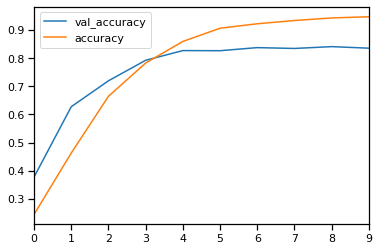

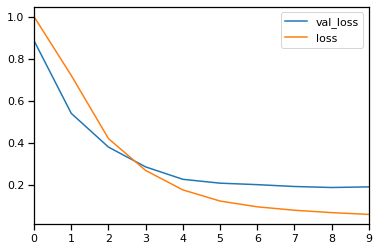

In [66]:
#Plotting the performance
df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [69]:
#On dev data 
loss, accuracy = model.evaluate(dev_sentences, dev_tags_1hot,
                       batch_size=batch_size, verbose=1)

print('Test loss:', loss)
print('Test accuracy:', accuracy) #can be better 

32/32 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.84 - ETA: 0s - loss: 0.2014 - accuracy: 0.84 - ETA: 0s - loss: 0.1982 - accuracy: 0.83 - ETA: 0s - loss: 0.2059 - accuracy: 0.83 - ETA: 0s - loss: 0.2154 - accuracy: 0.82 - ETA: 0s - loss: 0.2163 - accuracy: 0.82 - 0s 10ms/step - loss: 0.2208 - accuracy: 0.8300
Test loss: 0.22075580060482025
Test accuracy: 0.8299694061279297


In [70]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.22075580060482025
Test accuracy: 0.8299694061279297


In [71]:
#On test data
loss, LSTM_test_accuracy = model.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy) # test is doing slightly better than dev

32/32 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.83 - ETA: 0s - loss: 0.2471 - accuracy: 0.82 - ETA: 0s - loss: 0.2279 - accuracy: 0.82 - ETA: 0s - loss: 0.2276 - accuracy: 0.81 - ETA: 0s - loss: 0.2289 - accuracy: 0.81 - ETA: 0s - loss: 0.2213 - accuracy: 0.82 - ETA: 0s - loss: 0.2180 - accuracy: 0.82 - 0s 11ms/step - loss: 0.2180 - accuracy: 0.8252
Test loss: 0.21803560853004456
Test accuracy: 0.8299694061279297


In [72]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.21803560853004456
Test accuracy: 0.8299694061279297


In [75]:
strange_sentences = ['We are really enjoying NLP'.split()

                    ]
# convert to integers
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
# add padding
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(strange_sentences_int)
#print(predictions, predictions.shape)

def inverse_transform(sentences, predictions):
    output = []
    for sentence, prediction in zip(sentences, predictions):
        # find the index of the highest-scoring tag and translate it back
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(sentence))]
        output.append(token_sequence)
    return output

print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions)))) 

[(['We', 'are', 'really', 'enjoying', 'NLP'], ['VERB', 'VERB', 'ADV', 'VERB', 'ADV'])]


## Bi-LSTM 
Bidirectional now (both ends) 

In [76]:
# Random seed for reproducibility
np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
#wrap the LSTM in a Bidirectional wrapper
bilstm = Bidirectional(LSTM(units=256, 
                            return_sequences=True), 
                       name="Bi-LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(bilstm)
bilstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(bilstm_out)

model_bilstm = Model(inputs=[inputs], outputs=[output])
model_bilstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 26)]              0         
_________________________________________________________________
embeddings (Embedding)       (None, 26, 128)           384128    
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 26, 512)           788480    
_________________________________________________________________
dropout (Dropout)            (None, 26, 512)           0         
_________________________________________________________________
output (Dense)               (None, 26, 22)            11286     
_________________________________________________________________
softmax (Activation)         (None, 26, 22)            0         
Total params: 1,183,894
Trainable params: 1,183,894
Non-trainable params: 0
_________________________________________________

Epoch 1/10
50/50 [==============================] - ETA: 3:42 - loss: 1.0032 - accuracy: 0.00 - ETA: 3s - loss: 1.0007 - accuracy: 0.0334 - ETA: 3s - loss: 1.0335 - accuracy: 0.05 - ETA: 3s - loss: 1.0485 - accuracy: 0.07 - ETA: 2s - loss: 1.0672 - accuracy: 0.09 - ETA: 2s - loss: 1.0795 - accuracy: 0.11 - ETA: 2s - loss: 1.0899 - accuracy: 0.13 - ETA: 2s - loss: 1.0965 - accuracy: 0.14 - ETA: 2s - loss: 1.1011 - accuracy: 0.15 - ETA: 2s - loss: 1.1043 - accuracy: 0.16 - ETA: 2s - loss: 1.1068 - accuracy: 0.16 - ETA: 2s - loss: 1.1079 - accuracy: 0.17 - ETA: 2s - loss: 1.1082 - accuracy: 0.17 - ETA: 2s - loss: 1.1078 - accuracy: 0.18 - ETA: 2s - loss: 1.1065 - accuracy: 0.18 - ETA: 2s - loss: 1.1048 - accuracy: 0.18 - ETA: 2s - loss: 1.1036 - accuracy: 0.19 - ETA: 2s - loss: 1.1030 - accuracy: 0.19 - ETA: 2s - loss: 1.1028 - accuracy: 0.19 - ETA: 2s - loss: 1.1019 - accuracy: 0.19 - ETA: 1s - loss: 1.1009 - accuracy: 0.19 - ETA: 1s - loss: 1.0998 - accuracy: 0.20 - ETA: 1s - loss: 1.09

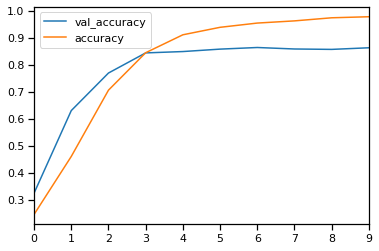

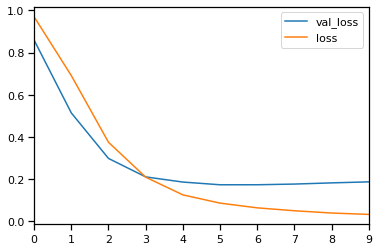

In [77]:
batch_size = 16
epochs = 10 
            

model_bilstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history_bilstm = model_bilstm.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

df = pd.DataFrame(history_bilstm.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [78]:
#On dev data 
loss, accuracy = model_bilstm.evaluate(dev_sentences, dev_tags_1hot,
                       batch_size=batch_size, verbose=1)

print('Dev loss:', loss)
print('Dev accuracy:', accuracy) #can be better 

32/32 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.87 - ETA: 0s - loss: 0.1883 - accuracy: 0.85 - ETA: 0s - loss: 0.1861 - accuracy: 0.86 - ETA: 0s - loss: 0.1807 - accuracy: 0.86 - ETA: 0s - loss: 0.1947 - accuracy: 0.86 - ETA: 0s - loss: 0.2025 - accuracy: 0.85 - ETA: 0s - loss: 0.2035 - accuracy: 0.85 - ETA: 0s - loss: 0.2027 - accuracy: 0.85 - ETA: 0s - loss: 0.2077 - accuracy: 0.85 - 0s 15ms/step - loss: 0.2077 - accuracy: 0.8563
Dev loss: 0.20765502750873566
Dev accuracy: 0.856269121170044


In [79]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.20765502750873566
Test accuracy: 0.856269121170044


In [80]:
#On test data
loss, BI_LSTM_test_accuracy = model_bilstm.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)

print('Test loss:', loss)
print('Test accuracy:', accuracy) #better than unidirectional but still and slightly better than dev

32/32 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.83 - ETA: 0s - loss: 0.2515 - accuracy: 0.84 - ETA: 0s - loss: 0.2242 - accuracy: 0.84 - ETA: 0s - loss: 0.2118 - accuracy: 0.85 - ETA: 0s - loss: 0.2178 - accuracy: 0.85 - ETA: 0s - loss: 0.2115 - accuracy: 0.85 - ETA: 0s - loss: 0.2086 - accuracy: 0.85 - ETA: 0s - loss: 0.2059 - accuracy: 0.85 - 0s 14ms/step - loss: 0.2022 - accuracy: 0.8570
Test loss: 0.20224440097808838
Test accuracy: 0.856269121170044


In [81]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.20224440097808838
Test accuracy: 0.856269121170044


In [82]:
#Checking on my previous sentences I wrote arbitrarily
predictions_bilstm = model_bilstm.predict(strange_sentences_int)
print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions_bilstm))))

[(['We', 'are', 'really', 'enjoying', 'NLP'], ['AUX', 'AUX', 'ADV', 'ADV', 'ADV'])]


In [85]:
pd.DataFrame(data=[[Greedy_test_accuracy,viterbi_test_accuracy,LSTM_test_accuracy,BI_LSTM_test_accuracy]],columns=['Greedy','viterbi','LSTM0','BI-LSTM'],index=['Test Accuracy'])

,Greedy,viterbi,LSTM0,BI-LSTM
Test Accuracy,0.842687,0.804847,0.825224,0.857021
